# Wikidata Knowledge Graph Extraction

Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs (KGs) as an external source of information. We found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's not possible to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps covered are:

How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
How to find surrounding entities and descriptions for an entity
Create a KG for Movielens

In [3]:
# set the environment path to find Recommenders
import sys
import re
print("System version: {}".format(sys.version))

import pyspark
from pyspark.sql.functions import col, udf

import papermill as pm
import scrapbook as sb
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from itertools import chain
from recommenders.datasets import movielens

from recommenders.datasets.wikidata import (search_wikidata, 
                                         find_wikidata_id, 
                                         query_entity_links, 
                                         read_linked_entities,
                                         query_entity_description)

System version: 3.9.12 (main, May  8 2022, 14:00:45) 
[Clang 10.0.1 (clang-1001.0.46.4)]


## 0 Load Dataset

In [4]:
DATA_PATH='../data/amazon_reviews_us_Electronics_v1_00.tsv'

COL_USER = "customer_id"
COL_ITEM = "product_id"
COL_RATING = "star_rating"
COL_PREDICTION = "star_rating"
COL_TIMESTAMP = "review_date"

In [5]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
data = spark.read.option("delimiter", "\t").option("header", True).csv(DATA_PATH)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/18 11:46:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
data.show(2)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41409413|R2MTG1GCZLR2DK|B00428R89M|     112201306|yoomall 5M Antenn...|     Electronics|          5|            0|          0|   N|                Y|          Five Stars|       As described.| 2015-08-31|
|         US|   49668221|R2HBOEM8LE9928|B000068O48|     734576678|Hosa GPM-103 3.5m...|     Electronics|          5|    

In [7]:
t = data.select(col('product_title')).collect()

In [8]:
t[230842]

Row(product_title='niceEshop(TM) 2.5mm Male to 3.5mm Female Stereo Audio Jack Adapter Cable,Black')

#### Create a list of words from all the product titles to model with the knowledge graph

In [9]:
from pyspark.sql.functions import lit

sw = stopwords.words('english')

def has_numbers(inputString):
  return any(char.isdigit() for char in inputString)
def has_alpha(inputString):
  return any(char.isalpha() for char in inputString)
def remove_special_characters(inputString):
  inputString = re.sub("[^A-Za-z]", "", inputString)
  return inputString
def transform_title(title):
  words = title.split(" ")
  words = [w for w in words if w not in sw]
  words = [w for w in words if not has_numbers(w) and has_alpha(w)]
  words = [remove_special_characters(w) for w in words] 
  return " ".join(words)

In [10]:
from pyspark.sql.functions import udf
transform_title_udf = udf(lambda x: transform_title(x))
titles = data.select(transform_title_udf(col("product_title")).alias("title_words")).collect()

In [11]:
titles = [t[0].split(" ") for t in titles]
titles = list(chain.from_iterable(titles))

In [19]:
len(titles)

26101800

## 1.Create a KG from linked entities in Wikidata

In [50]:
%%time

# the following code has been wrapped in a helper function called search_wikidata()
# it is provided here to show the details of which calls are being made to wikipedia APIs

# capture results as a list of dicts to transform to DataFrame (this is faster than appending to DataFrame)
results_list = []
for idx, name in enumerate(titles[2900:2983]):
  # first get the wikipedia entity id for each name
  entity_id = find_wikidata_id(name)
  if entity_id == "entityNotFound": continue

  #next we query wikipedia to get entity links
  json_links = query_entity_links(entity_id)

  # the following function extracts entities from the links
  related_links = read_linked_entities(json_links)

  # construct a connection in the graph between two entities
  for related_entity, related_name in related_links:
    result = dict(
      name=name,
      original_entity=entity_id,
      linked_entities=related_entity,
      name_linked_entities=related_name,
    )
    results_list.append(result)  
    
results_list = pd.DataFrame(results_list)
results_list.head()

ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND
ENTITY NOT FOUND


CPU times: user 1.06 s, sys: 164 ms, total: 1.22 s
Wall time: 40.1 s


,name,original_entity,linked_entities,name_linked_entities
0,Display,Q1229206,Q4167410,Wikimedia disambiguation page
1,Display,Q1229206,Q1229206,Display
2,EdisonBright,Q8743,Q131524,entrepreneur
3,EdisonBright,Q8743,Q14208553,invention
4,EdisonBright,Q8743,Q205375,inventor


## Visualize KG using network

In [51]:
G = nx.from_pandas_edgelist(results_list, 'original_entity', 'linked_entities')

In [52]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

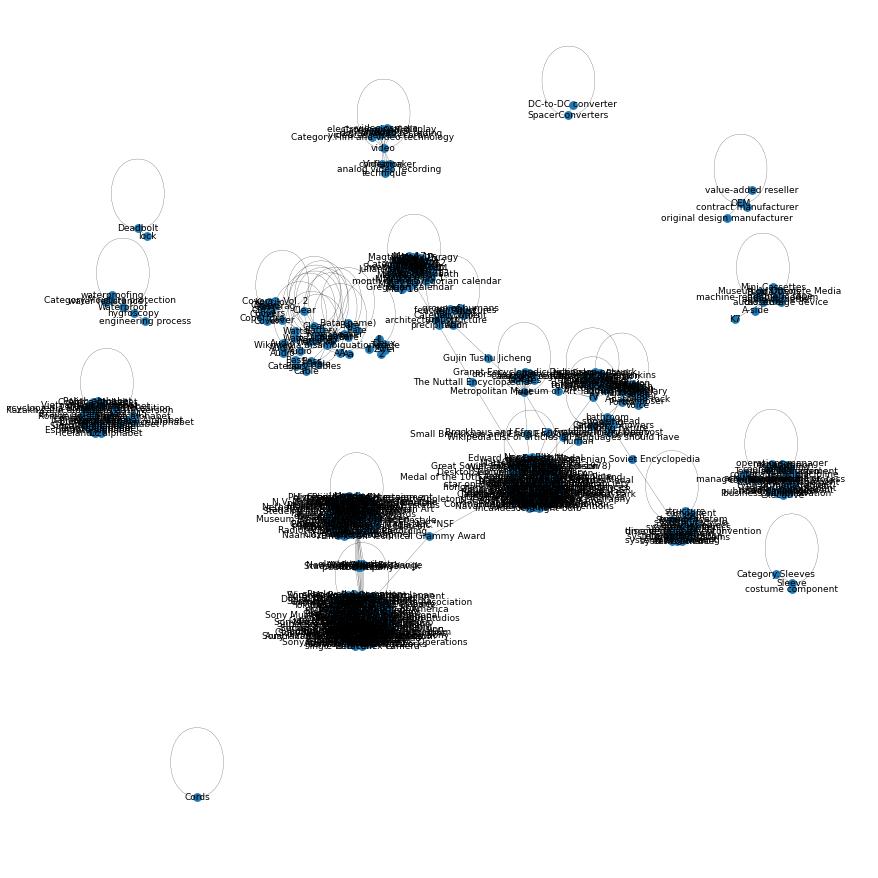

In [53]:
plt.figure(figsize=(12,12)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.savefig('foo.png')
plt.show()